Code for examining how HMM performs under repeated recalibration


In [148]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from hmm import HMMRecalibration
import hmm_utils
import simulation_utils 
from simulation import simulateBCIFitts
import stabilizer_utils
from stabilizer_utils import Stabilizer

# for a reproducible result
np.random.seed(1)

fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [ ]:
def simulate_MultiSessionStretch(base_opts, hmm = None, ss_opts = None):
    
    cfg_dict   = dict()
    order_dict = {'norecal_cfg' : 0, 'supervised_cfg' : 1}
    cfg_dict['supervised_cfg'] = simulation_utils.initializeBCI(base_opts)
    cfg_dict['norecal_cfg']    = simulation_utils.initializeBCI(base_opts)
    
    if hmm is not None:
        cfg_dict['hmm_cfg']   = simulation_utils.initializeBCI(base_opts)
        order_dict['hmm_cfg'] = len(order_dict.keys())
    if ss_opts is not None:
        cfg_dict['ss_cfg'], ss_decoder_dict, stabilizer = simulation_utils.initializeBCI({**base_opts, **ss_opts})
        cfg_dict['ss_cfg']['neuralTuning'][:, 0] = 0
        order_dict['ss_cfg'] = len(order_dict.keys())

    session_scores = np.zeros((base_opts['n_sessions'] + 1, len(cfg_dict.keys())))
    
    # Day 0 performance:
    D_dict = dict()
    for key, cfg in cfg_dict.items():
        D_key         = key.split('cfg')[0] + 'D'
        D_dict[D_key] = np.copy(cfg_dict[key]['D'])
        
    #ss_cfg['D'][:, 0]   = ss_cfg['D'][:,0] / np.linalg.norm(ss_cfg['D'][1:, :][:, 0]) / np.linalg.norm(ss_tuning[:, 1])
    #ss_cfg['D'][:, 1]   = ss_cfg['D'][:,1] / np.linalg.norm(ss_cfg['D'][1:, :][:, 1]) / np.linalg.norm(ss_tuning[:, 2])   
        
    for i, (key, value) in enumerate(cfg_dict.items()):
        session_scores[0, order_dict[key]] = np.mean(simulateBCIFitts(value)['ttt'])

    
    for i in range(base_opts['n_sessions']):
        for j in range(base_opts['days_between'] + 1):
            for key, cfg in cfg_dict.items():
                # introduce daily nonstationarities between recorded sessions
                cfg['neuralTuning'] = simulation_utils.simulateTuningShift(cfg['neuralTuning'], n_stable = 10, PD_shrinkage = base_opts['shrinkage'], 
                                                                  mean_shift = 0, renormalize = simulation_utils.sampleSNR())  
        
        # No recalibration:
        D_dict['norecal_D'][:, 0] = D_dict['norecal_D'][:,0] / np.linalg.norm(D_dict['norecal_D'][1:, :][:, 0]) / np.linalg.norm(cfg_dict['norecal_cfg']['neuralTuning'][:, 1])
        D_dict['norecal_D'][:, 1] = D_dict['norecal_D'][:,1] / np.linalg.norm(D_dict['norecal_D'][1:, :][:, 1]) / np.linalg.norm(cfg_dict['norecal_cfg']['neuralTuning'][:, 2])        

        cfg_dict['norecal_cfg']['D']    = D_dict['norecal_D']
        cfg_dict['norecal_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['norecal_cfg'], possibleGain = np.linspace(0.1,2.5,10))
        
        idx                          = order_dict['norecal_cfg']
        session_scores[i+1, idx] = np.mean(simulateBCIFitts(cfg_dict['norecal_cfg'])['ttt'])
        
        # supervised: 
        cfg_dict['supervised_cfg']['D'] = simulation_utils.simulate_OpenLoopRecalibration(cfg_dict['supervised_cfg'], nSteps = 10000)
        cfg_dict['supervised_cfg']['D'] = simulation_utils.simulate_ClosedLoopRecalibration(cfg_dict['supervised_cfg'])
        idx                             = order_dict['supervised_cfg']
        
        cfg_dict['supervised_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['supervised_cfg'], 
                                                                       possibleGain = np.linspace(0.1,2.5,10))
        
        session_scores[i+1, idx]        = np.mean(simulateBCIFitts(cfg_dict['supervised_cfg'])['ttt'])
        
        '''
        print('--------------------------------')
        print(i, ': ttt = ', session_scores[i+1, idx])
        print('gain = ', cfg_dict['supervised_cfg']['beta'])
        print('decoder norm: ', np.linalg.norm(cfg_dict['supervised_cfg']['D'][1:, :], axis = 0))
        x_corr = np.corrcoef(cfg_dict['supervised_cfg']['D'][1:, :].T, cfg_dict['supervised_cfg']['neuralTuning'][:, 1:].T)[0, 2]
        y_corr = np.corrcoef(cfg_dict['supervised_cfg']['D'][1:, :].T, cfg_dict['supervised_cfg']['neuralTuning'][:, 1:].T)[1, 3]
        print('x corr: ', x_corr)
        print('y corr: ', y_corr)

        if session_scores[i+1, idx] > 10 and i > 2:
            return cfg_dict['supervised_cfg'], ss_decoder_dict, stabilizer, ss_opts
        '''

        # HMM recalibration (repeated):   
        if hmm is not None:
            cfg_dict['hmm_cfg']['D'] = simulation_utils.simulate_HMMRecalibration(cfg_dict['hmm_cfg'], hmm)
            idx                      = order_dict['hmm_cfg']
            session_scores[i+1, idx] = np.mean(simulateBCIFitts(cfg_dict['hmm_cfg'])['ttt'])
        
        # stabilizer:
        if ss_opts is not None:
            cfg_dict['ss_cfg']['D'] = simulation_utils.simulate_LatentClosedLoopRecalibration(cfg_dict['ss_cfg'], ss_decoder_dict, stabilizer, ss_opts)
            #ss_cfg['D'][:, 0]       = ss_cfg['D'][:,0] / np.linalg.norm(ss_cfg['D'][1:, :][:, 0]) / np.linalg.norm(ss_tuning[:, 1])
            #ss_cfg['D'][:, 1]       = ss_cfg['D'][:,1] / np.linalg.norm(ss_cfg['D'][1:, :][:, 1]) / np.linalg.norm(ss_tuning[:, 2])   
            
            cfg_dict['ss_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['ss_cfg'], possibleGain = np.linspace(0.1,2.5,10))
            
            idx                      = order_dict['ss_cfg']
            session_scores[i+1, idx] = np.mean(simulateBCIFitts(cfg_dict['ss_cfg'])['ttt'])
            
            '''
            print('--------------------------------')
            print(i, ': ttt = ', session_scores[i+1, idx])
            print('gain = ', cfg_dict['ss_cfg']['beta'])
            print('decoder norm: ', np.linalg.norm(cfg_dict['ss_cfg']['D'][1:, :], axis = 0))
            x_corr = np.corrcoef(cfg_dict['ss_cfg']['D'][1:, :].T, cfg_dict['ss_cfg']['neuralTuning'][:, 1:].T)[0, 2]
            y_corr = np.corrcoef(cfg_dict['ss_cfg']['D'][1:, :].T, cfg_dict['ss_cfg']['neuralTuning'][:, 1:].T)[1, 3]
            print('x corr: ', x_corr)
            print('y corr: ', y_corr)
            
            if session_scores[i+1, idx] < 3 and i > 7:
                return cfg_dict['ss_cfg'], ss_decoder_dict, stabilizer, ss_opts
            '''

    return session_scores
    
    
#TODO:
# - modify tuning to remove means (thats whats breaking subspace realignment here)
# - modify so each method gets its own initial tuning setup on day 0 and its own tuning shift 
#    - this will let you keep the independent samples t test 

In [ ]:
#x = simulate_MultiSessionStretch(*args[0])
y = simulate_MultiSessionStretch(*args[0])

KeyboardInterrupt: 

In [167]:
out = simulateBCIFitts(y[0])

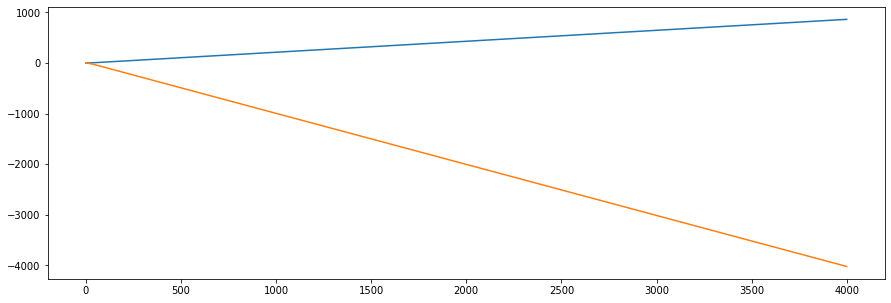

In [168]:
plt.plot(out['posTraj'][:4000, :])
plt.show()

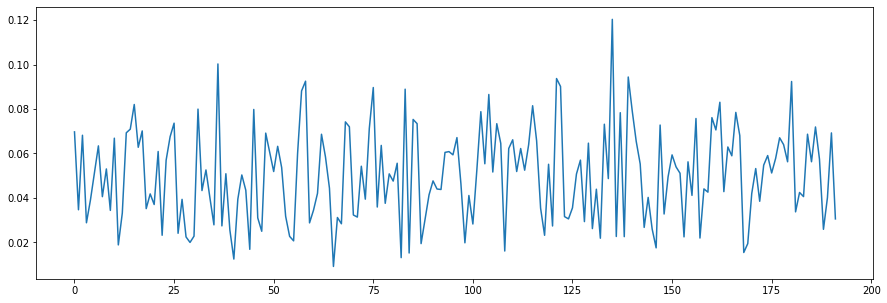

In [127]:
stab = y[2]

delta = np.linalg.norm(stab.ref_coefs - stab.new_coefs, axis = 1)
plt.plot(delta)
plt.show()

In [ ]:
import copy
from joblib import Parallel, delayed

np.random.seed(42)

# general settings:
reps  = 10   # how many times to repeat the repeated nonstationarities simulation


base_opts = dict()
base_opts['alpha']          = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
base_opts['delT']           = 0.02 # define the time step (20 ms)
base_opts['nDelaySteps']    = 10   # define the simulated user's visual feedback delay (200 ms)
base_opts['nSimSteps']      = 20000
base_opts['nUnits']         = 192
base_opts['SNR']            = 0.5
base_opts['possibleGain']   = np.linspace(0.1,2.5,10)
base_opts['center_means']   = False
base_opts['nTrainingSteps'] = 10000


base_opts['n_sessions']   = 30   # number of sessions to simulate 
base_opts['days_between'] = 0    # days between session days
base_opts['shrinkage']    = 0.9  # relative tuning in subspace per new day


# stabilizer settings:
ss_opts                 = dict()
ss_opts['B']            = 100
ss_opts['thresh']       = 0.01
ss_opts['n_components'] = 4
ss_opts['model_type']   = 'FactorAnalysis'

# HMM settings:
vmKappa    = 2          # Precision parameter for the von mises distribution
probThresh = 0.4        # todo: implement
gridSize   = 20
stayProb   = 0.9999
adjustKappa = lambda x: 1 / (1 + np.exp(-1 * (x - 0.15) * 5))


#-----------------------------------------
session_scores          = np.zeros((reps, base_opts['n_sessions'] + 1, 4)) 
targLocs                = hmm_utils.generateTargetGrid(gridSize = gridSize)
stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(gridSize = gridSize, stayProb = stayProb)
hmm                     = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa = adjustKappa)


args           = [[base_opts, None, ss_opts]] * reps
rep_data       = Parallel(n_jobs= -1, verbose = 11)(delayed(simulate_MultiSessionStretch)(*x) for x in args)
session_scores = np.dstack(rep_data).swapaxes(2, 0).swapaxes(1, 2)
    

In [ ]:
figSize(5, 15)
from lineplots import plotsd
import seaborn as sns 


#labels = ['None', 'Supervised', 'repeated HMM', 'subspace']
#colors = ['r', 'g', 'b', 'purple']

labels = ['None', 'Supervised', 'subspace']
colors = ['r', 'g', 'b']
days   = np.linspace(0, (base_opts['days_between'] + 1) * base_opts['n_sessions'], base_opts['n_sessions'] + 1)

plt.subplot(1, 2, 1)
for i, label in enumerate(labels):
    plotsd(data = session_scores[:, :, i], time_bins = days, color = colors[i], toggleSE = True)

plt.legend(labels, loc = 'upper left')
plt.title('Recalibration performance across time (alpha = ' + str(base_opts['shrinkage']) + ')')
plt.xlabel('Days')
plt.ylabel('Time to target (sec)')

plt.subplot(1, 3, 3)
plt_data = [session_scores[:, -1, i].flatten() for i in range(len(labels))]
sns.stripplot(data = plt_data)

#plt.savefig(fig_path + 'simulator/repeated_HMMrecal', format = 'pdf')
plt.show()


In [94]:
import scipy

print('None and supervised:, ', scipy.stats.ranksums(plt_data[0], plt_data[1]))
print('None and HMM:, ', scipy.stats.ranksums(plt_data[0], plt_data[2]))
print('supervised and HMM:, ', scipy.stats.ranksums(plt_data[1], plt_data[2]))

None and supervised:,  RanksumsResult(statistic=3.779644730092272, pvalue=0.00015705228423075119)
None and HMM:,  RanksumsResult(statistic=3.779644730092272, pvalue=0.00015705228423075119)
supervised and HMM:,  RanksumsResult(statistic=-0.5291502622129182, pvalue=0.5967012167293563)


In [34]:
session_scores.shape

(15, 31, 4)